In [1]:

from utils import csv_to_dict, show_images, show_images_single, bb_intersection_over_union
import pandas as pd
import numpy as np
import json
from collections import defaultdict

In [2]:
# Process CSV file and convert to dictionary (key by image path) and will gather bounding boxes
json_path = '../data/test_split.json'
#csv_data = pd.read_csv(train_csv_path)
#dict_data = csv_to_dict(csv_data=csv_data)
with open(json_path, 'r') as file:
    dict_data = json.load(file)

# Process CSV file and convert to dictionary (key by image path) and will gather bounding boxes
result_csv_path = '../data/evaluation.csv'
csv_data = pd.read_csv(result_csv_path)
result_dict_data = csv_to_dict(csv_data=csv_data)

In [3]:
images_to_print = defaultdict(list)
groundTruth_mage = defaultdict(list)
mislabeled, bad_iou, unpaired, total_bb = 0,0,0,0
all_problematic_bb = []
accurate_predictions = defaultdict(list)
accurate_ground_truth = defaultdict(list)

for key in dict_data.keys():
    ground_truth_bb = []
    ground_truth_centroids = []
    model_output_bb = []
    model_output_centroids = []
    problematic_bb = []
  
    for label_dict in dict_data[key]:
        #ground truth boxes
        xmax, xmin, ymax, ymin = [label_dict.get(key) for key in ['xmax', 'xmin', 'ymax', 'ymin']]
        total_bb+=1
        ground_truth_bb.append([xmin, ymin, xmax, ymax])
        #print(xmax, xmin, ymax, ymin)

    
    for label_dict in result_dict_data[key]:
        #model result boxes
        xmax, xmin, ymax, ymin = [label_dict.get(key) for key in ['xmax', 'xmin', 'ymax', 'ymin']]     
        model_output_bb.append([xmin, ymin, xmax, ymax])

    num_gt_bbox = len(ground_truth_bb)
    num_mo_bbox = len(model_output_bb)
    iou_table = np.zeros((num_gt_bbox, num_mo_bbox))

    for i, bb_ground_truth in enumerate(ground_truth_bb):
        for j, bb_model in enumerate(model_output_bb):
            iou_table[i,j] = bb_intersection_over_union(bb_ground_truth, bb_model)
    
    
    # algorithm to pair the model output bboxes to ground truth bboxes
    # while we have an unassigned gt bbox or there are no more mo bboxes
    #   let u,v be the location of the maximum value in iou_table
    #   create the gt-mo pair (u,v)
    #   zero out the u-th row of iou_table and the v-th column of iou_table
    paired_bbs = [] # ~ a list of tuples of paired bounding boxes
    problematic_bb = []
    gt_bb_inds = np.ones(num_gt_bbox)
    mo_bb_inds = np.ones(num_mo_bbox)
    while np.sum(gt_bb_inds) and np.sum(mo_bb_inds) and iou_table[:].sum():
        u, v = np.unravel_index(iou_table.argmax(), iou_table.shape)
        #print(iou_table)
        #print(u,v)
        #print(gt_bb_inds)
        #print(mo_bb_inds)

        # [u].name != [v].name?
        #Then we found one that has different class names so lets just continue and not add
        #that to the list of paired_bbs
        if dict_data.get(key)[u].get('name') != result_dict_data.get(key)[v].get('name'):
            #good IOU, labels don't match
            mislabeled+=1
            problematic_bb.append((u,v))
            all_problematic_bb.append((u,v))
            gt_bb_inds[u] = 0
            mo_bb_inds[v] = 0
            iou_table[u,:] = 0.0
            iou_table[:,v] = 0.0

            #Need to capture the ground truth image once
            images_to_print[key].append(result_dict_data.get(key)[v])
            groundTruth_mage[key].append(dict_data.get(key)[u])

            continue

        if dict_data.get(key)[u].get('name') == result_dict_data.get(key)[v].get('name') and iou_table[u,v] < 0.5:
            #bad IOU, labels match
            bad_iou+=1
            problematic_bb.append((u,v))
            all_problematic_bb.append((u,v))
            gt_bb_inds[u] = 0
            mo_bb_inds[v] = 0
            iou_table[u,:] = 0.0
            iou_table[:,v] = 0.0

            #Need to capture the ground truth image once
            images_to_print[key].append(result_dict_data.get(key)[v])
            groundTruth_mage[key].append(dict_data.get(key)[u])

            continue

       
        gt_bb_inds[u] = 0
        mo_bb_inds[v] = 0
        iou_table[u,:] = 0.0
        iou_table[:,v] = 0.0

        accurate_predictions[key].append(result_dict_data.get(key)[v])
        accurate_ground_truth[key].append(dict_data.get(key)[u])


    for i in gt_bb_inds:
        if i == 1:
            unpaired+=1
            problematic_bb.append(i)
            all_problematic_bb.append((u,v))
    for j in mo_bb_inds:
        if j == 1:
            unpaired+=1
            problematic_bb.append(j)  
            all_problematic_bb.append((u,v))

In [4]:
print("Statistics: ")
print("Number of total bb's in ground truth set: ", total_bb)
print("Number of problematic bb's: ", len(all_problematic_bb))
print("/*%* of problematic bb's: ", ((len(all_problematic_bb))/(total_bb)*100))
print("Number of mislabeled: ", mislabeled)
print("Correctly labeled but low IOU: ", bad_iou)
print("Unpaired boxes: ", unpaired)

Statistics: 
Number of total bb's in ground truth set:  1954
Number of problematic bb's:  11960
/*%* of problematic bb's:  612.0777891504606
Number of mislabeled:  184
Correctly labeled but low IOU:  199
Unpaired boxes:  11577


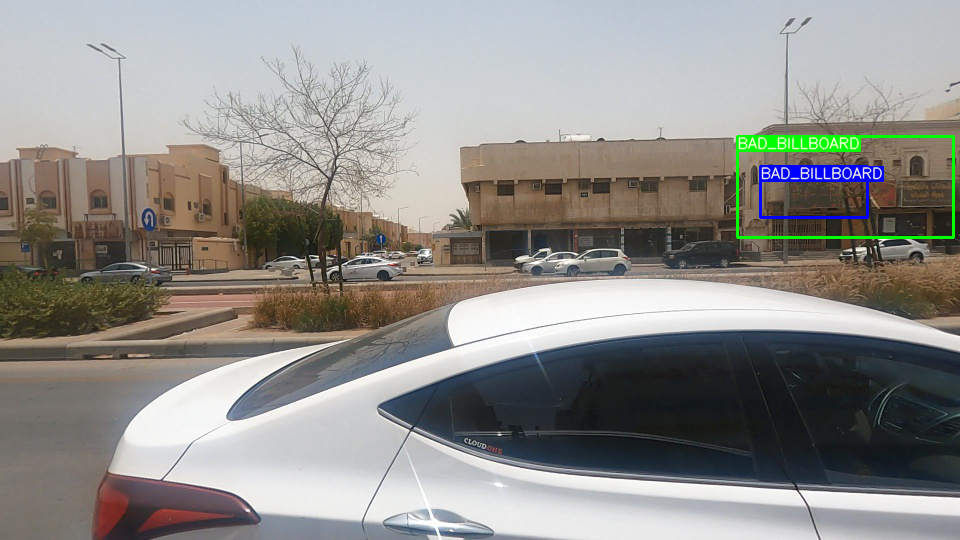

In [5]:
show_images(groundTruth_mage,images_to_print)